In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model, Sequential

## 1.- Preprocesamiento de los datos

In [3]:
fdata = pd.read_csv('data_histories.csv', index_col="dp_folio")
fdata.head()

,id_sexo,Aedad,AAedad,Apuesto,id_gestud,AIMC,fuma,fuma_act,ejer_act,ejer1,...,locout5,locout10,locout20,locout30,rest_act,rest1,rest5,rest10,rest20,rest30
dp_folio,,,,,,,,,,,,,,,,,,,,,
1,F,51,6,Admin,CarTec,4,1,3,0,2,...,1,1,1,1,0,0,0,0,0,0
2,F,38,4,Sec,Bach,3,2,-1,0,0,...,0,0,0,0,1,3,0,0,0,0
3,F,34,3,Int,Sec,5,1,1,0,0,...,1,-1,-1,-1,0,0,0,-1,-1,-1
4,M,63,8,Jef,CarTec,4,2,-1,2,2,...,0,0,0,-1,0,0,0,0,0,0
5,M,42,4,EM,Sec,3,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0


### Funciones para clusterizar/discretizar los datos

In [4]:
#Function to clusterize categories of a certain feature, and add the new clusterized feature as a new column
# Clusters should be an input of the form {cluster_A: {categories}, cluster_B: [categories]}
# Ex. obesity = {0:[1,2,3], 1:[4,5,6]}
def clusterizeDiscrete(feature, clusters, new_name, data):
    new_data = data.copy()
    original_list = data.loc[1:1080, feature]
    new_list = []
    for index in original_list.index:
        cat = False
        if original_list[index] == -1 or original_list[index] == "-1":
            new_list.append("N")
            continue
        for cluster in clusters:
            if original_list[index] in clusters[cluster]:
                new_list.append(cluster)
                cat = True
        if cat == False:
            new_list.append("N")
    new_data[new_name] = new_list
    return new_data

# Function to clusterize categories of a certain continous feature, and add the new clusterized feature as a
# new column
# Clusters shoud be an input of the form {cluster_A: {lambdaFunction1}, cluster_B: lambdaFunction2}
def clusterizeContinuous(feature, clusters, new_name, data):
    new_data = data.copy()
    original_list = data.loc[1:1080, feature]
    new_list = []
    for index in original_list.index:
        if original_list[index] == -1 or original_list[index] == "-1":
            new_list.append("N")
            continue
        for cluster in clusters:
            if eval(clusters[cluster])(original_list[index]):
                new_list.append(cluster)
                break
    new_data[new_name] = new_list
    return new_data
        

# Set of auxiliary high-order functions that will evaluate the conditions to binarize a history
def lessThan(num):
    return lambda n: n < num

def lessQThan(num):
    return lambda n: n <= num

def greaterThan(num):
    return lambda n: n > num

def greaterQThan(num):
    return lambda n: n >= num

def between(num1, num2):
    return lambda n: n <= num2 and n >= num1

### Definición y creación de los clusters

In [5]:
# Clusterize between obese and non obese
obesity = {0:[1,2,3], 1:[4,5,6]}
ndata = clusterizeDiscrete("AIMC", obesity, "obesity", fdata)

# Clusterize between degrees of study (higher degree vs. non higher degree)
degree = {0:["Prim", "Sec", "Bach", "CarTec", "Otro"], 1:["Lic", "Mast", "Doc", "PDoc"]}
ndata = clusterizeDiscrete("id_gestud", degree, "hdegree", ndata)

# Clusterize excercise features
ejer = {"A":"greaterQThan(2.5)", "B":"lessThan(2.5)"}
ndata = clusterizeContinuous("ejer_act", ejer, "ejer0B", ndata)
ndata = clusterizeContinuous("ejer1", ejer, "ejer1B", ndata)
ndata = clusterizeContinuous("ejer5", ejer, "ejer5B", ndata)
ndata = clusterizeContinuous("ejer10", ejer, "ejer10B", ndata)
ndata = clusterizeContinuous("ejer20", ejer, "ejer20B", ndata)
ndata = clusterizeContinuous("ejer30", ejer, "ejer30B", ndata)

# Clusterize stress features
estres = {"A":[4,5], "B":[1,2,3]}
ndata = clusterizeDiscrete("estres_act", estres, "estres0B", ndata)
ndata = clusterizeDiscrete("estres1", estres, "estres1B", ndata)
ndata = clusterizeDiscrete("estres5", estres, "estres5B", ndata)
ndata = clusterizeDiscrete("estres10", estres, "estres10B", ndata)
ndata = clusterizeDiscrete("estres20", estres, "estres20B", ndata)
ndata = clusterizeDiscrete("estres30", estres, "estres30B", ndata)

# Clusterize weight features
peso = {"A":[1,2,3], "B":[4,5]}
ndata = clusterizeDiscrete("peso_act", peso, "peso0B", ndata)
ndata = clusterizeDiscrete("peso1", peso, "peso1B", ndata)
ndata = clusterizeDiscrete("peso5", peso, "peso5B", ndata)
ndata = clusterizeDiscrete("peso10", peso, "peso10B", ndata)
ndata = clusterizeDiscrete("peso20", peso, "peso20B", ndata)
ndata = clusterizeDiscrete("peso30", peso, "peso30B", ndata)

# Clusterize weight features
condi = {"A":[4,5], "B":[1,2,3]}
ndata = clusterizeDiscrete("condi_act", condi, "condi0B", ndata)
ndata = clusterizeDiscrete("condi1", condi, "condi1B", ndata)
ndata = clusterizeDiscrete("condi5", condi, "condi5B", ndata)
ndata = clusterizeDiscrete("condi10", condi, "condi10B", ndata)
ndata = clusterizeDiscrete("condi20", condi, "condi20B", ndata)
ndata = clusterizeDiscrete("condi30", condi, "condi30B", ndata)

# Clusterize health features
salud = {"A":[4,5], "B":[1,2,3]}
ndata = clusterizeDiscrete("salud_act", salud, "salud0B", ndata)
ndata = clusterizeDiscrete("salud1", salud, "salud1B", ndata)
ndata = clusterizeDiscrete("salud5", salud, "salud5B", ndata)
ndata = clusterizeDiscrete("salud10", salud, "salud10B", ndata)
ndata = clusterizeDiscrete("salud20", salud, "salud20B", ndata)
ndata = clusterizeDiscrete("salud30", salud, "salud30B", ndata)

# Clusterize job features
academic = {0:["Admin", "Asi", "Coo", "E", "ED", "EM", "Int", "Jef", "Lab", "Sec", "Tec", "Vig"], 1:["Acade", "Inv", "InvE"]}
ndata = clusterizeDiscrete("Apuesto", academic, "academic", ndata)

# Clusterize walking features
walking = {"A":"greaterQThan(1800.0)", "B":"lessThan(1800.0)"}
ndata = clusterizeContinuous("dis_dia", walking, "dis_dia0B", ndata)
ndata = clusterizeContinuous("dis1_dia", walking, "dis_dia1B", ndata)
ndata = clusterizeContinuous("dis5_dia", walking, "dis_dia5B", ndata)
ndata = clusterizeContinuous("dis10_dia", walking, "dis_dia10B", ndata)
ndata = clusterizeContinuous("dis20_dia", walking, "dis_dia20B", ndata)
ndata = clusterizeContinuous("dis30_dia", walking, "dis_dia30B", ndata)


# Clusterize age features
age = {0:"between(15.0, 28.0)", 1:"between(28.1, 40.0)", 2:"between(40.1, 60.0)", 3:"between(60.1, 90.0)"}
ndata = clusterizeContinuous("Aedad", age, "AedadC", ndata)

In [7]:
ndata.head()

,id_sexo,Aedad,AAedad,Apuesto,id_gestud,AIMC,fuma,fuma_act,ejer_act,ejer1,...,salud20B,salud30B,academic,dis_dia0B,dis_dia1B,dis_dia5B,dis_dia10B,dis_dia20B,dis_dia30B,AedadC
dp_folio,,,,,,,,,,,,,,,,,,,,,
1,F,51,6,Admin,CarTec,4,1,3,0,2,...,A,A,0,B,B,A,N,N,N,2
2,F,38,4,Sec,Bach,3,2,-1,0,0,...,A,A,0,A,B,B,B,A,B,1
3,F,34,3,Int,Sec,5,1,1,0,0,...,A,N,0,B,B,B,B,B,B,1
4,M,63,8,Jef,CarTec,4,2,-1,2,2,...,A,A,0,A,A,A,A,A,A,3
5,M,42,4,EM,Sec,3,1,2,2,2,...,N,N,0,B,B,B,N,N,N,2


### Creación de la matriz de variables (features)

In [168]:
# Build profile based on excercise, health and stress in the last 0, 1, 5 and 10 years
profiles_0_to_10 = ndata[["ejer0B", "salud0B", "estres0B", "ejer1B", "salud1B", "estres1B", "ejer5B", "salud5B", "estres5B", "ejer10B", "salud10B", "estres10B"]]
profiles_1_to_10 = ndata[["ejer1B", "salud1B", "estres1B", "ejer5B", "salud5B", "estres5B", "ejer10B", "salud10B", "estres10B"]]

# Replace "A" with 1, and "B" with 0, in order to have binary values, and save this in the feature matrix X
X_0 = profiles_0_to_10.replace("A", 1).replace("B", 0).replace("N", 0)
X_1 = profiles_1_to_10.replace("A", 1).replace("B", 0).replace("N", 0)

In [9]:
X_0.head()

,ejer0B,salud0B,estres0B,ejer1B,salud1B,estres1B,ejer5B,salud5B,estres5B,ejer10B,salud10B,estres10B
dp_folio,,,,,,,,,,,,
1,0,1,1,0,1,0,0,1,1,0,1,0
2,0,1,0,0,1,0,1,0,1,1,1,0
3,0,0,1,0,0,1,0,1,1,1,1,1
4,0,1,0,0,1,1,1,1,0,1,1,0
5,0,1,0,0,1,0,0,0,0,0,0,1


## 2.- RBM

In [161]:
# Simple function to split a set between batches
def batch_iterator(X, y=None, batch_size=64):
    n_samples = X.shape[0]
    for i in np.arange(0, n_samples, batch_size):
        begin, end = i, min(i+batch_size, n_samples)
        if y is not None:
            yield X[begin:end], y[begin:end]
        else:
            yield X[begin:end]

In [200]:
# Classic Restricted Boltzmann Machine
class RBM :
    
    def __init__(self, num_visible, num_hidden, learning_rate, batch_size, num_epochs):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        self.W = np.random.normal(scale=0.1, size=(num_visible, num_hidden))
        self.a = np.zeros(num_visible)
        self.b = np.zeros(num_hidden)
    
    # Calculate the sigmoid of X 
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-1*X))
    
    # Sample the activations given a certain matrix of probabilities
    def sample(self, X):
        return X > np.random.random_sample(size=X.shape)
    
    # Perform a reconstruction of the input data X
    def gibbs_sample(self, X):
        # Positive phase: Calculate the activations of the hidden layer
        positive_hidden = self.sigmoid(X.dot(self.W) + self.b)
        hidden_states = self.sample(positive_hidden)
        # Negative phase: Given the activations of the hidden layer, reconstruct the states at the visible layer
        negative_visible = self.sigmoid(hidden_states.dot(self.W.T) + self.a)
        visible_states = self.sample(negative_visible)
        return visible_states
    
    # Get the hidden probabilities for a certain input
    def transform(self, X):
        return self.sigmoid(X.dot(self.W) + self.b)
    
    def train(self, X):
        
        # Define matrix to keep track of the training MSE
        self.training_errors = []
        
        for epoch in range(self.num_epochs):
            
            batch_errors = []
            
            for batch in batch_iterator(X, batch_size=self.batch_size):
                
                V = np.array(batch.values[:, :])
                
                # Positive phase: Calculate the activations of the hidden layer
                positive_hidden_probs = self.sigmoid(V.dot(self.W) + self.b)
                positive_hidden_states = self.sample(positive_hidden_probs)
                
                # Calculate vh_data using the positive hidden states activations, rather than their probabilities
                # as per Hinton (2010)
                vh_data = V.T.dot(positive_hidden_probs)
                
                # Negative phase
                negative_visible_probs = self.sigmoid(positive_hidden_states.dot(self.W.T) + self.a)
                negative_visible_states = self.sample(negative_visible_probs)
                negative_hidden_probs = self.sigmoid(negative_visible_states.dot(self.W) + self.b)
                negative_hidden_states = self.sample(negative_hidden_probs)
                
                # Calculate vh_reconstruction using the negative hidden states activations
                vh_reconstruction = negative_visible_states.T.dot(negative_hidden_probs)
                
                # Update weights and biases
                self.W += self.learning_rate * (vh_data - vh_reconstruction)
                self.b += self.learning_rate * (positive_hidden_probs.sum(axis=0) - negative_hidden_probs.sum(axis=0))
                self.a += self.learning_rate * (V.sum(axis=0) - negative_visible_probs.sum(axis=0))
                
                batch_errors.append(np.mean((batch - negative_visible_states) ** 2))
                                    
            self.training_errors.append(np.mean(batch_errors))
                

In [204]:
rbm = RBM(12, 100, 0.001, 10, 10)

In [205]:
rbm.train(X_0)

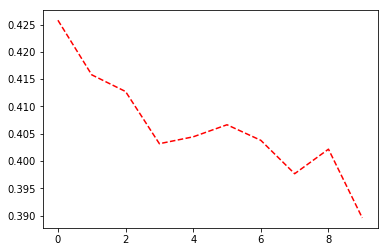

In [207]:
t = np.arange(0, 10, 1)
plt.plot(t, rbm.training_errors, 'r--')
plt.show()

In [17]:
print X_0.iloc[0].values
print rbm.transform(X_0.iloc[0])
print rbm.gibbs_sample(X_0.iloc[0])

[0 1 1 0 1 0 0 1 1 0 1 0]
[0.60889946 0.80303995 0.46998722 0.55433747 0.36101767 0.20545923
 0.72815807 0.48834093 0.19979814 0.17960557 0.17463372 0.72545378
 0.62787513 0.12231737 0.11172597 0.28895445 0.16971215 0.34480183
 0.26181296 0.03861048 0.10808959 0.72482407 0.41822369 0.42031089
 0.32047238 0.63525524 0.13745157 0.14437388 0.92337478 0.39315135
 0.42805542 0.28253326 0.78576351 0.38447825 0.44063888 0.80843876
 0.27810606 0.24629606 0.17614566 0.89797747 0.38095588 0.70792281
 0.09712514 0.26486428 0.70618919 0.38405368 0.10340371 0.50469286
 0.81330176 0.0989912  0.52514859 0.82798329 0.1057779  0.69012806
 0.21369683 0.77909484 0.257992   0.28669396 0.16751718 0.16000579
 0.72787704 0.0371351  0.02894645 0.58105468 0.25580632 0.08268622
 0.14270009 0.46437016 0.02814419 0.35974685 0.80635405 0.24464735
 0.25630834 0.32727505 0.23107092 0.53966419 0.55386806 0.25228184
 0.49203663 0.6206693  0.63929452 0.58993501 0.95698083 0.07248105
 0.31299221 0.20072095 0.46461795 0.

## 3.- CRBM

In [80]:
# Conditional / Temporally Restricted Boltzmann Machine
class CRBM :
    
    def __init__(self, num_visible, num_hidden, num_historic, learning_rate, batch_size, num_epochs):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.num_historic = num_historic
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        # Initialize weights and biases
        self.W = np.random.normal(scale=0.1, size=(num_visible, num_hidden))
        self.a = np.zeros(num_visible)
        self.b = np.zeros(num_hidden)
        
        # Initialize autoregreesive parameters
        self.A = np.random.normal(scale=0.01, size=(num_visible, num_historic))
        self.B = np.random.normal(scale=0.01, size=(num_hidden, num_historic))
    
    # Calculate the sigmoid of X 
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-1*X))
    
    # Sample the activations given a certain matrix of probabilities
    def sample(self, X):
        return X > np.random.random_sample(size=X.shape)
    
    # Perform a reconstruction of the input data X
    def gibbs_sample(self, X):
        
        # Separate input vector
        V = np.array(X.values[:, :3])
        H = np.array(X.values[:, 3:])

        # Positive phase

        # Calculate the contributions from the Historic layer
        dinamic_b = self.b + H.dot(self.B.T)

        # Calculate the activations of the Hidden layer
        positive_hidden = sigmoid(V.dot(self.W) + dinamic_b)
        hidden_states = sample(positive_hidden)

        # Negative phase

        #Calculate the contributions from the Historic layer
        dinamic_a = self.a + H.dot(self.A.T)
        
        # Calculate the activations of the Visible layer
        negative_visible = sigmoid(hidden_states.dot(self.W.T) + dinamic_a)
        visible_states = sample(negative_visible)
        return visible_states
    
    # Get the hidden probabilities for a certain input
    def transform(self, X):
        V = np.array(X.values[:, :3])
        H = np.array(X.values[:, 3:])
        dinamic_b = self.b + H.dot(self.B.T)
        return self.sigmoid(V.dot(self.W) + dinamic_b)
    
    def train(self, X):
        
        # Define matrix to keep track of the training MSE
        self.training_errors = []
        
        for epoch in range(self.num_epochs):
            
            batch_errors = []
            
            for batch in batch_iterator(X, batch_size=self.batch_size):
                
                # Separate input vector
                V = np.array(batch.values[:, :3])
                H = np.array(batch.values[:, 3:])
                
                
                # Positive phase
                # Calculate the contributions from the Historic layer
                dinamic_b = self.b + H.dot(self.B.T)
                
                # Calculate the activations of the hidden layer
                positive_hidden_probs = self.sigmoid(V.dot(self.W) + dinamic_b)
                positive_hidden_states = self.sample(positive_hidden_probs)
                
                # Calculate vh_data using the positive hidden probabilities, rather than their activations
                # as per Hinton (2010)
                vh_data = V.T.dot(positive_hidden_probs)
                
                # Calculate vH_data (H: Historic layer)
                vH_data = V.T.dot(H)
                # Calculate hH_data (H: Historic layer)
                hH_data = positive_hidden_states.T.dot(H)
                
                
                
                # Negative phase
                
                # Calculate the contributions from the Historic layer
                dinamic_a = self.a + H.dot(self.A.T)
                
                negative_visible_probs = self.sigmoid(positive_hidden_states.dot(self.W.T) + dinamic_a)
                negative_visible_states = self.sample(negative_visible_probs)
                negative_hidden_probs = self.sigmoid(negative_visible_states.dot(self.W) + dinamic_b)
                negative_hidden_states = self.sample(negative_hidden_probs)
                
                # Calculate vh_reconstruction using the negative hidden states probabilities
                vh_reconstruction = negative_visible_states.T.dot(negative_hidden_probs)
                
                # Calculate vH_reconstruction (H: Historic layer)
                vH_reconstruction = negative_visible_states.T.dot(H)
                # Calculate hH_reconstruction (H: Historic layer)
                hH_reconstruction = negative_hidden_states.T.dot(H)
                
                # Update weights and biases
                self.W += self.learning_rate * (vh_data - vh_reconstruction)
                self.b += self.learning_rate * (positive_hidden_probs.sum(axis=0) - negative_hidden_probs.sum(axis=0))
                self.a += self.learning_rate * (V.sum(axis=0) - negative_visible_probs.sum(axis=0))
                self.B += self.learning_rate * 0.01 * (hH_data - hH_reconstruction)
                self.A += self.learning_rate * 0.01 * (vH_data - vH_reconstruction)
                
                batch_errors.append(np.mean((V - negative_visible_states) ** 2))
            #print "Epoch " + str(epoch) + " - MSE: " + str(np.mean(batch_errors))                        
            self.training_errors.append(np.mean(batch_errors))
                

In [112]:
crbm = CRBM(3, 100, 9, 0.001, 10, 1000)

In [113]:
crbm.train(X_0)

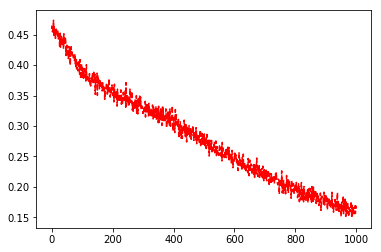

In [114]:
t = np.arange(0, 1000, 1)
plt.plot(t, crbm.training_errors, 'r--')
plt.show()

In [105]:
crbm.transform(X_0).shape

(1076, 100)

## 4.- SRBM

In [145]:
# Socially Restricted Boltzmann Machine
class SRBM :
    
    def __init__(self, num_visible, num_hidden, num_historic, learning_rate, batch_size, num_epochs):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.num_historic = num_historic
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
    # Calculate the sigmoid of X 
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-1*X))
    
    # Initialize parameters
    def initialize(self):
        # Initialize weights and biases
        self.W = np.random.normal(scale=0.1, size=(self.num_visible, self.num_hidden))
        self.a = np.zeros(self.num_visible)
        self.b = np.zeros(self.num_hidden)
        
        # Initialize autoregreesive parameters
        self.A = np.random.normal(scale=0.01, size=(self.num_visible, self.num_historic))
        self.B = np.random.normal(scale=0.01, size=(self.num_hidden, self.num_historic))
    
    
    # Sample the activations given a certain matrix of probabilities
    def sample(self, X):
        return X > np.random.random_sample(size=X.shape)
    
    # Perform a reconstruction of the input data X
    def gibbs_sample(self, X):
        
        # Create Historic layer
        H = np.tile(self.historic, (len(X), 1))
        
        # Separate input vector
        V = np.array(X.values[:, :3])

        # Positive phase

        # Calculate the contributions from the Historic layer
        dinamic_b = self.b + H.dot(self.B.T)

        # Calculate the activations of the Hidden layer
        positive_hidden = sigmoid(V.dot(self.W) + dinamic_b)
        hidden_states = sample(positive_hidden)

        # Negative phase

        #Calculate the contributions from the Historic layer
        dinamic_a = self.a + H.dot(self.A.T)
        
        # Calculate the activations of the Visible layer
        negative_visible = sigmoid(hidden_states.dot(self.W.T) + dinamic_a)
        visible_states = sample(negative_visible)
        return visible_states
    
    # Get the hidden probabilities for a certain input
    def transform(self, X):
        # Separate input vector
        V = np.array(X.values[:, :3])
        # Create Historic layer
        H = np.tile(self.historic, (len(X), 1))
        dinamic_b = self.b + H.dot(self.B.T)
        return self.sigmoid(V.dot(self.W) + dinamic_b)
    
    def train(self, X):
        
        # Define matrix to keep track of the training MSE
        self.training_errors = []
        
        self.historic = []
        for id in X.values[:, 3:]:
            for value in id:
                self.historic.append(value)
                
        self.num_historic = len(self.historic)
        self.initialize()
        
        for epoch in range(self.num_epochs):
            
            batch_errors = []
            
            for batch in batch_iterator(X, batch_size=self.batch_size):
                
                # Separate input vector
                V = np.array(batch.values[:, :3])   
                
                # Create Historic layer
                H = np.tile(self.historic, (len(batch), 1))
                #print H.shape
                
                # Positive phase
                # Calculate the contributions from the Historic layer
                dinamic_b = self.b + H.dot(self.B.T)
                
                # Calculate the activations of the hidden layer
                positive_hidden_probs = self.sigmoid(V.dot(self.W) + dinamic_b)
                positive_hidden_states = self.sample(positive_hidden_probs)
                
                # Calculate vh_data using the positive hidden probabilities, rather than their activations
                # as per Hinton (2010)
                vh_data = V.T.dot(positive_hidden_probs)
                
                # Calculate vH_data (H: Historic layer)
                vH_data = V.T.dot(H)
                # Calculate hH_data (H: Historic layer)
                hH_data = positive_hidden_states.T.dot(H)
                
                
                
                # Negative phase
                
                # Calculate the contributions from the Historic layer
                dinamic_a = self.a + H.dot(self.A.T)
                
                negative_visible_probs = self.sigmoid(positive_hidden_states.dot(self.W.T) + dinamic_a)
                negative_visible_states = self.sample(negative_visible_probs)
                negative_hidden_probs = self.sigmoid(negative_visible_states.dot(self.W) + dinamic_b)
                negative_hidden_states = self.sample(negative_hidden_probs)
                
                # Calculate vh_reconstruction using the negative hidden states probabilities
                vh_reconstruction = negative_visible_states.T.dot(negative_hidden_probs)
                
                # Calculate vH_reconstruction (H: Historic layer)
                vH_reconstruction = negative_visible_states.T.dot(H)
                # Calculate hH_reconstruction (H: Historic layer)
                hH_reconstruction = negative_hidden_states.T.dot(H)
                
                # Update weights and biases
                self.W += self.learning_rate * (vh_data - vh_reconstruction)
                self.b += self.learning_rate * (positive_hidden_probs.sum(axis=0) - negative_hidden_probs.sum(axis=0))
                self.a += self.learning_rate * (V.sum(axis=0) - negative_visible_probs.sum(axis=0))
                self.B += self.learning_rate * 0.001 * (hH_data - hH_reconstruction)
                self.A += self.learning_rate * 0.001 * (vH_data - vH_reconstruction)
                #print dinamic_a
                #print H.dot(self.A.T).sum()
                #print dinamic_b
                
                batch_errors.append(np.mean((V - negative_visible_states) ** 2))
            print "Epoch " + str(epoch) + " - MSE: " + str(np.mean(batch_errors))                        
            self.training_errors.append(np.mean(batch_errors))
                

In [149]:
srbm = SRBM(3, 200, 9684, 0.001, 10, 50)

In [147]:
srbm.train(X_0)

Epoch 0 - MSE: 0.425514403292181


KeyboardInterrupt: 

## 5.- Autoencoder

In [97]:
dim = X_0.shape[-1]
encoding_dim = 8

# Define the input layer
inputs = Input(shape=(dim,))

# Define the encoding layer (turns inputs into an encoded representation)
encoded = Dense(encoding_dim, activation='relu')(inputs)

# Define the decoding layer (turns the encoded representation into a decoded output)
decoded = Dense(dim, activation='sigmoid')(encoded)

# Define the autoencoder
autoencoder = Model(inputs, decoded)

# Define the encoder (this will be used for the classification purposes)
encoder = Model(inputs, encoded)

In [98]:
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [154]:
# Train the autoencoder
autoencoder.fit(X_0, X_0, epochs=500, batch_size=10)

Epoch 1/500
1076/1076 [==============================] - 0s 31us/step - loss: 0.0155
Epoch 2/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0149
Epoch 3/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0149
Epoch 4/500
1076/1076 [==============================] - 0s 30us/step - loss: 0.0147
Epoch 5/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0146
Epoch 6/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0146
Epoch 7/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0146
Epoch 8/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0146
Epoch 9/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0146
Epoch 10/500
1076/1076 [==============================] - 0s 31us/step - loss: 0.0145
Epoch 11/500
1076/1076 [==============================] - 0s 30us/step - loss: 0.0146
Epoch 12/500
1076/1076 [==============================] - 0s 36

1076/1076 [==============================] - 0s 30us/step - loss: 0.0142
Epoch 97/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0142
Epoch 98/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0142
Epoch 99/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0141
Epoch 100/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0142
Epoch 101/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0144
Epoch 102/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0143
Epoch 103/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0143
Epoch 104/500
1076/1076 [==============================] - 0s 31us/step - loss: 0.0142
Epoch 105/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0142
Epoch 106/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0142
Epoch 107/500
1076/1076 [==============================] - 0

1076/1076 [==============================] - 0s 28us/step - loss: 0.0141
Epoch 191/500
1076/1076 [==============================] - 0s 30us/step - loss: 0.0140
Epoch 192/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0141
Epoch 193/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0141
Epoch 194/500
1076/1076 [==============================] - 0s 31us/step - loss: 0.0141
Epoch 195/500
1076/1076 [==============================] - 0s 31us/step - loss: 0.0140
Epoch 196/500
1076/1076 [==============================] - 0s 30us/step - loss: 0.0141
Epoch 197/500
1076/1076 [==============================] - 0s 31us/step - loss: 0.0141
Epoch 198/500
1076/1076 [==============================] - 0s 31us/step - loss: 0.0141
Epoch 199/500
1076/1076 [==============================] - 0s 31us/step - loss: 0.0141
Epoch 200/500
1076/1076 [==============================] - 0s 30us/step - loss: 0.0140
Epoch 201/500
1076/1076 [==============================] 

1076/1076 [==============================] - 0s 32us/step - loss: 0.0141
Epoch 285/500
1076/1076 [==============================] - 0s 31us/step - loss: 0.0139
Epoch 286/500
1076/1076 [==============================] - 0s 37us/step - loss: 0.0141
Epoch 287/500
1076/1076 [==============================] - 0s 32us/step - loss: 0.0139
Epoch 288/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0140
Epoch 289/500
1076/1076 [==============================] - 0s 30us/step - loss: 0.0140
Epoch 290/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0139
Epoch 291/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0141
Epoch 292/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0140
Epoch 293/500
1076/1076 [==============================] - 0s 26us/step - loss: 0.0140
Epoch 294/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0140
Epoch 295/500
1076/1076 [==============================] 

1076/1076 [==============================] - 0s 31us/step - loss: 0.0138
Epoch 379/500
1076/1076 [==============================] - 0s 33us/step - loss: 0.0138
Epoch 380/500
1076/1076 [==============================] - 0s 33us/step - loss: 0.0138
Epoch 381/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0138
Epoch 382/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0138
Epoch 383/500
1076/1076 [==============================] - 0s 30us/step - loss: 0.0137
Epoch 384/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0138
Epoch 385/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0139
Epoch 386/500
1076/1076 [==============================] - 0s 30us/step - loss: 0.0139
Epoch 387/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0138
Epoch 388/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0139
Epoch 389/500
1076/1076 [==============================] 

1076/1076 [==============================] - 0s 27us/step - loss: 0.0137
Epoch 473/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0137
Epoch 474/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0138
Epoch 475/500
1076/1076 [==============================] - 0s 30us/step - loss: 0.0138
Epoch 476/500
1076/1076 [==============================] - 0s 30us/step - loss: 0.0137
Epoch 477/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0138
Epoch 478/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0138
Epoch 479/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0136
Epoch 480/500
1076/1076 [==============================] - 0s 28us/step - loss: 0.0136
Epoch 481/500
1076/1076 [==============================] - 0s 27us/step - loss: 0.0138
Epoch 482/500
1076/1076 [==============================] - 0s 29us/step - loss: 0.0138
Epoch 483/500
1076/1076 [==============================] 

In [39]:
encoded_X = encoder.predict(X_0)
decoded_X = autoencoder.predict(X_0)

In [40]:
encoded_X

array([[ 2.1891625,  6.8406286,  5.1432614,  3.9384155],
       [ 5.207448 ,  6.920889 ,  3.693769 ,  3.227216 ],
       [ 7.089404 ,  6.9084816,  9.950967 ,  7.0531826],
       ...,
       [ 7.2621717, 10.82936  ,  3.737259 ,  4.067622 ],
       [ 1.6702967,  6.5954275,  4.198864 ,  3.736425 ],
       [ 9.116369 , 10.115728 , 10.285453 ,  7.2715836]], dtype=float32)

In [42]:
decoded_X

array([[0.01738257, 0.9927765 , 0.43040508, ..., 0.06821772, 0.98804593,
        0.14660467],
       [0.5196501 , 0.9419159 , 0.08828234, ..., 0.46727872, 0.92507005,
        0.07835862],
       [0.01850419, 0.10027114, 0.9981785 , ..., 0.4864678 , 0.94921803,
        0.26275584],
       ...,
       [0.65860146, 0.975266  , 0.04349445, ..., 0.9309587 , 0.991954  ,
        0.00675815],
       [0.01427043, 0.9902588 , 0.23455788, ..., 0.05328381, 0.98841304,
        0.08774268],
       [0.08193643, 0.43683678, 0.99615794, ..., 0.91500735, 0.98810774,
        0.09653149]], dtype=float32)

In [43]:
print decoded_X[0]
print X_0.iloc[0]

[0.01738257 0.9927765  0.43040508 0.00673529 0.995501   0.8340866
 0.00677111 0.9988181  0.35879216 0.06821772 0.98804593 0.14660467]
ejer0B       0
salud0B      1
estres0B     1
ejer1B       0
salud1B      1
estres1B     0
ejer5B       0
salud5B      1
estres5B     1
ejer10B      0
salud10B     1
estres10B    0
Name: 1, dtype: int64


## 6.- Predicción de Obesidad

In [66]:
# Dividir entre train y test
# Construir un clasificador (perceptron simple) con todos y comparar sus resultados:
# Entrenar todos los modelos. 5-fold validation y construir ROC de cada uno. (Ya no nos enfoquemos en los parámetros distintos)

In [30]:
# Libraries for ROC plots
from scipy import interp
from sklearn.metrics import roc_curve, auc

# Libraries for Cross Validation
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import KFold

# Libraries for Logistic Regression
from sklearn.linear_model import LogisticRegression

In [156]:
# Build profile based on excercise, health and stress in the last 0, 1, 5 and 10 years
profiles_0_to_10_wO = ndata[["ejer0B", "salud0B", "estres0B", "ejer1B", "salud1B", "estres1B", "ejer5B", "salud5B", "estres5B", "ejer10B", "salud10B", "estres10B", "obesity"]]
profiles_1_to_10_wO = ndata[["ejer1B", "salud1B", "estres1B", "ejer5B", "salud5B", "estres5B", "ejer10B", "salud10B", "estres10B", "obesity"]]


# Replace "A" with 1, and "B" with 0, in order to have binary values, and save this in the feature matrix X
X_Full = profiles_1_to_10_wO.replace("A", 1).replace("B", 0).replace("N", 0)

In [157]:
X_Full.iloc[:, :-1].head()

,ejer1B,salud1B,estres1B,ejer5B,salud5B,estres5B,ejer10B,salud10B,estres10B
dp_folio,,,,,,,,,
1,0,1,0,0,1,1,0,1,0
2,0,1,0,1,0,1,1,1,0
3,0,0,1,0,1,1,1,1,1
4,0,1,1,1,1,0,1,1,0
5,0,1,0,0,0,0,0,0,1


In [33]:
kf = KFold(n_splits = 5, shuffle=True)

In [34]:
for train_index, test_index in kf.split(X_Full):
    train = []
    test = []
    for index in train_index:
        train.append(X_Full.iloc[index])
    train = np.array(train)
    for index in test_index:
        test.append(X_Full.iloc[index])
    test = np.array(test)

In [50]:
rbm.transform(train[:, :-1]).shape
#X_Full.iloc[:, -1:].shape
#train[:, -1:].flatten()

(861, 100)

In [180]:
# Perform a 5-fold cross validation for a chosen model
def run_cv(X, chosen_model, folds, name):
    
    lr = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
    kf = KFold(n_splits=folds, shuffle=True)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    j = 0
    for train_index, test_index in kf.split(X):
        train = []
        test = []
        for index in train_index:
            train.append(X.iloc[index])
        train = np.array(train)
        for index in test_index:
            test.append(X.iloc[index])
        test = np.array(test)
        Xt = pd.DataFrame(train[:, :-1])
        Yt = train[:, -1]
        Xv = pd.DataFrame(test[:, :-1])
        Yv = test[:, -1]
        
        print 'Training model'
        # Train the model
        chosen_model.train(Xt)
        
        print 'Fitting L'
        # Transform all the inputs given the chosen model and use that output to feed the LR
        lr.fit(chosen_model.transform(Xt), Yt)
        #print lr.score(Xv, Yv)
        
        Yh = lr.predict(chosen_model.transform(Xv))
        Yprob = lr.predict_proba(chosen_model.transform(Xv))
        
        fpr, tpr, thresholds = roc_curve(Yv, Yprob[:,1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label="ROC fold %d (AUC=%0.2f)" % (j + 1, roc_auc))
        j = j + 1
        
        print 'Model Done'
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, lw=2, color='b', alpha=0.8, label='Mean ROC (AUC=%0.2f)' % (mean_auc))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(name)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
           label='Random', alpha=.8)
    plt.legend(loc="lower right")
    plt.show()

In [181]:
rbm = RBM(9, 100, 0.001, 10, 1000)
run_cv(X_Full, rbm, 5, "Classic RBM")

Training model


KeyboardInterrupt: 

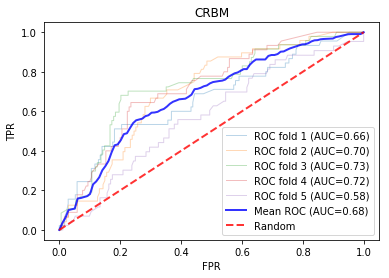

In [111]:
run_cv(X_Full, crbm, 5, "CRBM")

Epoch 0 - MSE: 0.4434108527131783
Epoch 1 - MSE: 0.44806201550387603
Epoch 2 - MSE: 0.4426356589147286
Epoch 3 - MSE: 0.4422480620155039
Epoch 4 - MSE: 0.44689922480620153
Epoch 5 - MSE: 0.43798449612403106
Epoch 6 - MSE: 0.4399224806201549
Epoch 7 - MSE: 0.44496124031007744
Epoch 8 - MSE: 0.44806201550387587
Epoch 9 - MSE: 0.4317829457364341
Epoch 10 - MSE: 0.44999999999999996
Epoch 11 - MSE: 0.43294573643410855
Epoch 12 - MSE: 0.42751937984496124
Epoch 13 - MSE: 0.4434108527131782
Epoch 14 - MSE: 0.43837209302325575
Epoch 15 - MSE: 0.4414728682170542
Epoch 16 - MSE: 0.42790697674418604
Epoch 17 - MSE: 0.4406976744186048
Epoch 18 - MSE: 0.45930232558139544
Epoch 19 - MSE: 0.43294573643410844
Epoch 20 - MSE: 0.4356589147286822
Epoch 21 - MSE: 0.4321705426356588
Epoch 22 - MSE: 0.44728682170542644
Epoch 23 - MSE: 0.41899224806201546
Epoch 24 - MSE: 0.4430232558139535
Epoch 25 - MSE: 0.43100775193798446
Epoch 26 - MSE: 0.43333333333333335
Epoch 27 - MSE: 0.4364341085271316
Epoch 28 - MSE

Epoch 33 - MSE: 0.4191570881226053
Epoch 34 - MSE: 0.43295019157088127
Epoch 35 - MSE: 0.42452107279693485
Epoch 36 - MSE: 0.4363984674329501
Epoch 37 - MSE: 0.4272030651340995
Epoch 38 - MSE: 0.4145593869731801
Epoch 39 - MSE: 0.4406130268199234
Epoch 40 - MSE: 0.41149425287356317
Epoch 41 - MSE: 0.4329501915708811
Epoch 42 - MSE: 0.41800766283524904
Epoch 43 - MSE: 0.4076628352490422
Epoch 44 - MSE: 0.41226053639846744
Epoch 45 - MSE: 0.42490421455938693
Epoch 46 - MSE: 0.424904214559387
Epoch 47 - MSE: 0.4245210727969349
Epoch 48 - MSE: 0.41800766283524904
Epoch 49 - MSE: 0.4191570881226052


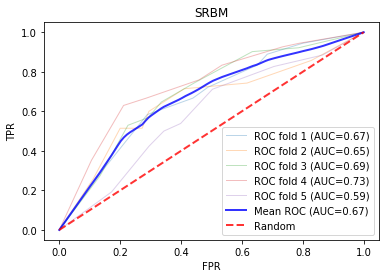

In [150]:
run_cv(X_Full, srbm, 5, "SRBM")

In [95]:
# Perform a 5-fold cross validation for a chosen model
def run_cv_autoencoder(X, chosen_model, folds, name):
    
    lr = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
    kf = KFold(n_splits=folds, shuffle=True)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    j = 0
    for train_index, test_index in kf.split(X):
        train = []
        test = []
        for index in train_index:
            train.append(X.iloc[index])
        train = np.array(train)
        for index in test_index:
            test.append(X.iloc[index])
        test = np.array(test)
        Xt = pd.DataFrame(train[:, :-1])
        Yt = train[:, -1]
        Xv = pd.DataFrame(test[:, :-1])
        Yv = test[:, -1]
        
        # Train the model
        chosen_model.fit(Xt, Xt, epochs=500, batch_size=10)
        
        # Transform all the inputs given the chosen model and use that output to feed the LR
        lr.fit(chosen_model.predict(Xt), Yt)
        #print lr.score(Xv, Yv)
        
        Yh = lr.predict(chosen_model.predict(Xv))
        Yprob = lr.predict_proba(chosen_model.predict(Xv))
        
        fpr, tpr, thresholds = roc_curve(Yv, Yprob[:,1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label="ROC fold %d (AUC=%0.2f)" % (j + 1, roc_auc))
        j = j + 1
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, lw=2, color='b', alpha=0.8, label='Mean ROC (AUC=%0.2f)' % (mean_auc))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(name)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
           label='Random', alpha=.8)
    plt.legend(loc="lower right")
    plt.show()

Epoch 1/500
860/860 [==============================] - 0s 28us/step - loss: 0.6984
Epoch 2/500
860/860 [==============================] - 0s 29us/step - loss: 0.6440
Epoch 3/500
860/860 [==============================] - 0s 30us/step - loss: 0.6054
Epoch 4/500
860/860 [==============================] - 0s 31us/step - loss: 0.5753
Epoch 5/500
860/860 [==============================] - 0s 29us/step - loss: 0.5423
Epoch 6/500
860/860 [==============================] - 0s 32us/step - loss: 0.4950
Epoch 7/500
860/860 [==============================] - 0s 34us/step - loss: 0.4562
Epoch 8/500
860/860 [==============================] - 0s 28us/step - loss: 0.4246
Epoch 9/500
860/860 [==============================] - 0s 31us/step - loss: 0.3975
Epoch 10/500
860/860 [==============================] - 0s 27us/step - loss: 0.3739
Epoch 11/500
860/860 [==============================] - 0s 24us/step - loss: 0.3520
Epoch 12/500
860/860 [==============================] - 0s 30us/step - loss: 0.3278
E

860/860 [==============================] - 0s 29us/step - loss: 0.0577
Epoch 99/500
860/860 [==============================] - 0s 33us/step - loss: 0.0575
Epoch 100/500
860/860 [==============================] - 0s 28us/step - loss: 0.0572
Epoch 101/500
860/860 [==============================] - 0s 27us/step - loss: 0.0568
Epoch 102/500
860/860 [==============================] - 0s 32us/step - loss: 0.0567
Epoch 103/500
860/860 [==============================] - 0s 27us/step - loss: 0.0563
Epoch 104/500
860/860 [==============================] - 0s 27us/step - loss: 0.0560
Epoch 105/500
860/860 [==============================] - 0s 27us/step - loss: 0.0558
Epoch 106/500
860/860 [==============================] - 0s 28us/step - loss: 0.0553
Epoch 107/500
860/860 [==============================] - 0s 27us/step - loss: 0.0550
Epoch 108/500
860/860 [==============================] - 0s 27us/step - loss: 0.0548
Epoch 109/500
860/860 [==============================] - 0s 27us/step - loss: 0.

860/860 [==============================] - 0s 27us/step - loss: 0.0380
Epoch 195/500
860/860 [==============================] - 0s 29us/step - loss: 0.0378
Epoch 196/500
860/860 [==============================] - 0s 27us/step - loss: 0.0376
Epoch 197/500
860/860 [==============================] - 0s 27us/step - loss: 0.0376
Epoch 198/500
860/860 [==============================] - 0s 28us/step - loss: 0.0374
Epoch 199/500
860/860 [==============================] - 0s 27us/step - loss: 0.0373
Epoch 200/500
860/860 [==============================] - 0s 27us/step - loss: 0.0371
Epoch 201/500
860/860 [==============================] - 0s 25us/step - loss: 0.0370
Epoch 202/500
860/860 [==============================] - 0s 29us/step - loss: 0.0368
Epoch 203/500
860/860 [==============================] - 0s 27us/step - loss: 0.0368
Epoch 204/500
860/860 [==============================] - 0s 28us/step - loss: 0.0366
Epoch 205/500
860/860 [==============================] - 0s 27us/step - loss: 0

860/860 [==============================] - 0s 26us/step - loss: 0.0299
Epoch 291/500
860/860 [==============================] - 0s 29us/step - loss: 0.0299
Epoch 292/500
860/860 [==============================] - 0s 27us/step - loss: 0.0298
Epoch 293/500
860/860 [==============================] - 0s 28us/step - loss: 0.0297
Epoch 294/500
860/860 [==============================] - 0s 27us/step - loss: 0.0297
Epoch 295/500
860/860 [==============================] - 0s 26us/step - loss: 0.0297
Epoch 296/500
860/860 [==============================] - 0s 27us/step - loss: 0.0296
Epoch 297/500
860/860 [==============================] - 0s 26us/step - loss: 0.0295
Epoch 298/500
860/860 [==============================] - 0s 28us/step - loss: 0.0296
Epoch 299/500
860/860 [==============================] - 0s 26us/step - loss: 0.0294
Epoch 300/500
860/860 [==============================] - 0s 26us/step - loss: 0.0296
Epoch 301/500
860/860 [==============================] - 0s 26us/step - loss: 0

860/860 [==============================] - 0s 28us/step - loss: 0.0266
Epoch 387/500
860/860 [==============================] - 0s 32us/step - loss: 0.0265
Epoch 388/500
860/860 [==============================] - 0s 28us/step - loss: 0.0266
Epoch 389/500
860/860 [==============================] - 0s 27us/step - loss: 0.0265
Epoch 390/500
860/860 [==============================] - 0s 28us/step - loss: 0.0264
Epoch 391/500
860/860 [==============================] - 0s 29us/step - loss: 0.0264
Epoch 392/500
860/860 [==============================] - 0s 28us/step - loss: 0.0264
Epoch 393/500
860/860 [==============================] - 0s 28us/step - loss: 0.0263
Epoch 394/500
860/860 [==============================] - 0s 27us/step - loss: 0.0262
Epoch 395/500
860/860 [==============================] - 0s 28us/step - loss: 0.0265
Epoch 396/500
860/860 [==============================] - 0s 27us/step - loss: 0.0263
Epoch 397/500
860/860 [==============================] - 0s 28us/step - loss: 0

860/860 [==============================] - 0s 26us/step - loss: 0.0246
Epoch 483/500
860/860 [==============================] - 0s 26us/step - loss: 0.0245
Epoch 484/500
860/860 [==============================] - 0s 26us/step - loss: 0.0245
Epoch 485/500
860/860 [==============================] - 0s 28us/step - loss: 0.0246
Epoch 486/500
860/860 [==============================] - 0s 27us/step - loss: 0.0246
Epoch 487/500
860/860 [==============================] - 0s 27us/step - loss: 0.0245
Epoch 488/500
860/860 [==============================] - 0s 27us/step - loss: 0.0244
Epoch 489/500
860/860 [==============================] - 0s 27us/step - loss: 0.0245
Epoch 490/500
860/860 [==============================] - 0s 29us/step - loss: 0.0245
Epoch 491/500
860/860 [==============================] - 0s 28us/step - loss: 0.0244
Epoch 492/500
860/860 [==============================] - 0s 28us/step - loss: 0.0245
Epoch 493/500
860/860 [==============================] - 0s 28us/step - loss: 0

861/861 [==============================] - 0s 29us/step - loss: 0.0216
Epoch 80/500
861/861 [==============================] - 0s 27us/step - loss: 0.0216
Epoch 81/500
861/861 [==============================] - 0s 28us/step - loss: 0.0215
Epoch 82/500
861/861 [==============================] - 0s 31us/step - loss: 0.0217
Epoch 83/500
861/861 [==============================] - 0s 28us/step - loss: 0.0217
Epoch 84/500
861/861 [==============================] - 0s 27us/step - loss: 0.0220
Epoch 85/500
861/861 [==============================] - 0s 29us/step - loss: 0.0214
Epoch 86/500
861/861 [==============================] - 0s 28us/step - loss: 0.0215
Epoch 87/500
861/861 [==============================] - 0s 28us/step - loss: 0.0214
Epoch 88/500
861/861 [==============================] - 0s 27us/step - loss: 0.0215
Epoch 89/500
861/861 [==============================] - 0s 30us/step - loss: 0.0215
Epoch 90/500
861/861 [==============================] - 0s 27us/step - loss: 0.0217
Epoch

861/861 [==============================] - 0s 28us/step - loss: 0.0197
Epoch 176/500
861/861 [==============================] - 0s 29us/step - loss: 0.0197
Epoch 177/500
861/861 [==============================] - 0s 27us/step - loss: 0.0196
Epoch 178/500
861/861 [==============================] - 0s 29us/step - loss: 0.0197
Epoch 179/500
861/861 [==============================] - 0s 29us/step - loss: 0.0196
Epoch 180/500
861/861 [==============================] - 0s 27us/step - loss: 0.0200
Epoch 181/500
861/861 [==============================] - 0s 28us/step - loss: 0.0196
Epoch 182/500
861/861 [==============================] - 0s 27us/step - loss: 0.0195
Epoch 183/500
861/861 [==============================] - 0s 27us/step - loss: 0.0196
Epoch 184/500
861/861 [==============================] - 0s 26us/step - loss: 0.0195
Epoch 185/500
861/861 [==============================] - 0s 26us/step - loss: 0.0194
Epoch 186/500
861/861 [==============================] - 0s 28us/step - loss: 0

861/861 [==============================] - 0s 28us/step - loss: 0.0182
Epoch 272/500
861/861 [==============================] - 0s 30us/step - loss: 0.0182
Epoch 273/500
861/861 [==============================] - 0s 31us/step - loss: 0.0182
Epoch 274/500
861/861 [==============================] - 0s 30us/step - loss: 0.0181
Epoch 275/500
861/861 [==============================] - 0s 30us/step - loss: 0.0182
Epoch 276/500
861/861 [==============================] - 0s 29us/step - loss: 0.0181
Epoch 277/500
861/861 [==============================] - 0s 29us/step - loss: 0.0181
Epoch 278/500
861/861 [==============================] - 0s 28us/step - loss: 0.0180
Epoch 279/500
861/861 [==============================] - 0s 27us/step - loss: 0.0181
Epoch 280/500
861/861 [==============================] - 0s 28us/step - loss: 0.0180
Epoch 281/500
861/861 [==============================] - 0s 29us/step - loss: 0.0180
Epoch 282/500
861/861 [==============================] - 0s 27us/step - loss: 0

861/861 [==============================] - 0s 28us/step - loss: 0.0173
Epoch 368/500
861/861 [==============================] - 0s 27us/step - loss: 0.0171
Epoch 369/500
861/861 [==============================] - 0s 27us/step - loss: 0.0171
Epoch 370/500
861/861 [==============================] - 0s 27us/step - loss: 0.0171
Epoch 371/500
861/861 [==============================] - 0s 29us/step - loss: 0.0171
Epoch 372/500
861/861 [==============================] - 0s 28us/step - loss: 0.0171
Epoch 373/500
861/861 [==============================] - 0s 27us/step - loss: 0.0170
Epoch 374/500
861/861 [==============================] - 0s 28us/step - loss: 0.0170
Epoch 375/500
861/861 [==============================] - 0s 28us/step - loss: 0.0171
Epoch 376/500
861/861 [==============================] - 0s 28us/step - loss: 0.0170
Epoch 377/500
861/861 [==============================] - 0s 27us/step - loss: 0.0170
Epoch 378/500
861/861 [==============================] - 0s 27us/step - loss: 0

861/861 [==============================] - 0s 32us/step - loss: 0.0163
Epoch 464/500
861/861 [==============================] - 0s 28us/step - loss: 0.0163
Epoch 465/500
861/861 [==============================] - 0s 27us/step - loss: 0.0162
Epoch 466/500
861/861 [==============================] - 0s 28us/step - loss: 0.0163
Epoch 467/500
861/861 [==============================] - 0s 28us/step - loss: 0.0163
Epoch 468/500
861/861 [==============================] - 0s 28us/step - loss: 0.0163
Epoch 469/500
861/861 [==============================] - 0s 28us/step - loss: 0.0163
Epoch 470/500
861/861 [==============================] - 0s 28us/step - loss: 0.0163
Epoch 471/500
861/861 [==============================] - 0s 27us/step - loss: 0.0162
Epoch 472/500
861/861 [==============================] - 0s 27us/step - loss: 0.0164
Epoch 473/500
861/861 [==============================] - 0s 27us/step - loss: 0.0161
Epoch 474/500
861/861 [==============================] - 0s 26us/step - loss: 0

861/861 [==============================] - 0s 28us/step - loss: 0.0199
Epoch 61/500
861/861 [==============================] - 0s 28us/step - loss: 0.0199
Epoch 62/500
861/861 [==============================] - 0s 28us/step - loss: 0.0198
Epoch 63/500
861/861 [==============================] - 0s 27us/step - loss: 0.0198
Epoch 64/500
861/861 [==============================] - 0s 27us/step - loss: 0.0197
Epoch 65/500
861/861 [==============================] - 0s 29us/step - loss: 0.0198
Epoch 66/500
861/861 [==============================] - 0s 32us/step - loss: 0.0198
Epoch 67/500
861/861 [==============================] - 0s 31us/step - loss: 0.0199
Epoch 68/500
861/861 [==============================] - 0s 31us/step - loss: 0.0198
Epoch 69/500
861/861 [==============================] - 0s 35us/step - loss: 0.0196
Epoch 70/500
861/861 [==============================] - 0s 31us/step - loss: 0.0198
Epoch 71/500
861/861 [==============================] - 0s 28us/step - loss: 0.0196
Epoch

861/861 [==============================] - 0s 26us/step - loss: 0.0187
Epoch 158/500
861/861 [==============================] - 0s 27us/step - loss: 0.0185
Epoch 159/500
861/861 [==============================] - 0s 28us/step - loss: 0.0186
Epoch 160/500
861/861 [==============================] - 0s 30us/step - loss: 0.0186
Epoch 161/500
861/861 [==============================] - 0s 26us/step - loss: 0.0185
Epoch 162/500
861/861 [==============================] - 0s 26us/step - loss: 0.0194
Epoch 163/500
861/861 [==============================] - 0s 26us/step - loss: 0.0187
Epoch 164/500
861/861 [==============================] - 0s 27us/step - loss: 0.0184
Epoch 165/500
861/861 [==============================] - 0s 27us/step - loss: 0.0185
Epoch 166/500
861/861 [==============================] - 0s 28us/step - loss: 0.0184
Epoch 167/500
861/861 [==============================] - 0s 26us/step - loss: 0.0183
Epoch 168/500
861/861 [==============================] - 0s 27us/step - loss: 0

861/861 [==============================] - 0s 28us/step - loss: 0.0176
Epoch 254/500
861/861 [==============================] - 0s 30us/step - loss: 0.0177
Epoch 255/500
861/861 [==============================] - 0s 29us/step - loss: 0.0175
Epoch 256/500
861/861 [==============================] - 0s 29us/step - loss: 0.0177
Epoch 257/500
861/861 [==============================] - 0s 29us/step - loss: 0.0176
Epoch 258/500
861/861 [==============================] - 0s 30us/step - loss: 0.0176
Epoch 259/500
861/861 [==============================] - 0s 32us/step - loss: 0.0177
Epoch 260/500
861/861 [==============================] - 0s 31us/step - loss: 0.0175
Epoch 261/500
861/861 [==============================] - 0s 27us/step - loss: 0.0176
Epoch 262/500
861/861 [==============================] - 0s 29us/step - loss: 0.0176
Epoch 263/500
861/861 [==============================] - 0s 29us/step - loss: 0.0175
Epoch 264/500
861/861 [==============================] - 0s 29us/step - loss: 0

861/861 [==============================] - 0s 27us/step - loss: 0.0170
Epoch 350/500
861/861 [==============================] - 0s 29us/step - loss: 0.0169
Epoch 351/500
861/861 [==============================] - 0s 28us/step - loss: 0.0169
Epoch 352/500
861/861 [==============================] - 0s 27us/step - loss: 0.0170
Epoch 353/500
861/861 [==============================] - 0s 28us/step - loss: 0.0169
Epoch 354/500
861/861 [==============================] - 0s 28us/step - loss: 0.0171
Epoch 355/500
861/861 [==============================] - 0s 29us/step - loss: 0.0169
Epoch 356/500
861/861 [==============================] - 0s 27us/step - loss: 0.0169
Epoch 357/500
861/861 [==============================] - 0s 28us/step - loss: 0.0170
Epoch 358/500
861/861 [==============================] - 0s 28us/step - loss: 0.0169
Epoch 359/500
861/861 [==============================] - 0s 29us/step - loss: 0.0171
Epoch 360/500
861/861 [==============================] - 0s 29us/step - loss: 0

861/861 [==============================] - 0s 27us/step - loss: 0.0165
Epoch 446/500
861/861 [==============================] - ETA: 0s - loss: 0.003 - 0s 28us/step - loss: 0.0166
Epoch 447/500
861/861 [==============================] - 0s 27us/step - loss: 0.0164
Epoch 448/500
861/861 [==============================] - 0s 27us/step - loss: 0.0167
Epoch 449/500
861/861 [==============================] - 0s 27us/step - loss: 0.0164
Epoch 450/500
861/861 [==============================] - 0s 27us/step - loss: 0.0165
Epoch 451/500
861/861 [==============================] - 0s 33us/step - loss: 0.0165
Epoch 452/500
861/861 [==============================] - 0s 31us/step - loss: 0.0164
Epoch 453/500
861/861 [==============================] - 0s 27us/step - loss: 0.0165
Epoch 454/500
861/861 [==============================] - 0s 29us/step - loss: 0.0165
Epoch 455/500
861/861 [==============================] - 0s 31us/step - loss: 0.0166
Epoch 456/500
861/861 [==============================] 

861/861 [==============================] - 0s 28us/step - loss: 0.0172
Epoch 42/500
861/861 [==============================] - 0s 30us/step - loss: 0.0173
Epoch 43/500
861/861 [==============================] - 0s 30us/step - loss: 0.0179
Epoch 44/500
861/861 [==============================] - 0s 29us/step - loss: 0.0171
Epoch 45/500
861/861 [==============================] - 0s 30us/step - loss: 0.0172
Epoch 46/500
861/861 [==============================] - 0s 30us/step - loss: 0.0171
Epoch 47/500
861/861 [==============================] - 0s 28us/step - loss: 0.0170
Epoch 48/500
861/861 [==============================] - 0s 31us/step - loss: 0.0173
Epoch 49/500
861/861 [==============================] - 0s 29us/step - loss: 0.0170
Epoch 50/500
861/861 [==============================] - 0s 29us/step - loss: 0.0172
Epoch 51/500
861/861 [==============================] - 0s 28us/step - loss: 0.0168
Epoch 52/500
861/861 [==============================] - 0s 28us/step - loss: 0.0169
Epoch

861/861 [==============================] - 0s 28us/step - loss: 0.0160
Epoch 139/500
861/861 [==============================] - 0s 34us/step - loss: 0.0160
Epoch 140/500
861/861 [==============================] - 0s 28us/step - loss: 0.0160
Epoch 141/500
861/861 [==============================] - 0s 28us/step - loss: 0.0160
Epoch 142/500
861/861 [==============================] - 0s 29us/step - loss: 0.0160
Epoch 143/500
861/861 [==============================] - 0s 29us/step - loss: 0.0159
Epoch 144/500
861/861 [==============================] - 0s 28us/step - loss: 0.0163
Epoch 145/500
861/861 [==============================] - 0s 28us/step - loss: 0.0159
Epoch 146/500
861/861 [==============================] - 0s 28us/step - loss: 0.0159
Epoch 147/500
861/861 [==============================] - 0s 28us/step - loss: 0.0159
Epoch 148/500
861/861 [==============================] - 0s 27us/step - loss: 0.0159
Epoch 149/500
861/861 [==============================] - 0s 27us/step - loss: 0

861/861 [==============================] - 0s 29us/step - loss: 0.0157
Epoch 235/500
861/861 [==============================] - 0s 27us/step - loss: 0.0155
Epoch 236/500
861/861 [==============================] - 0s 28us/step - loss: 0.0154
Epoch 237/500
861/861 [==============================] - 0s 27us/step - loss: 0.0156
Epoch 238/500
861/861 [==============================] - 0s 28us/step - loss: 0.0155
Epoch 239/500
861/861 [==============================] - 0s 27us/step - loss: 0.0155
Epoch 240/500
861/861 [==============================] - 0s 29us/step - loss: 0.0156
Epoch 241/500
861/861 [==============================] - 0s 28us/step - loss: 0.0155
Epoch 242/500
861/861 [==============================] - 0s 27us/step - loss: 0.0154
Epoch 243/500
861/861 [==============================] - 0s 26us/step - loss: 0.0155
Epoch 244/500
861/861 [==============================] - 0s 27us/step - loss: 0.0156
Epoch 245/500
861/861 [==============================] - 0s 27us/step - loss: 0

861/861 [==============================] - 0s 28us/step - loss: 0.0151
Epoch 331/500
861/861 [==============================] - 0s 28us/step - loss: 0.0151
Epoch 332/500
861/861 [==============================] - 0s 27us/step - loss: 0.0152
Epoch 333/500
861/861 [==============================] - 0s 29us/step - loss: 0.0151
Epoch 334/500
861/861 [==============================] - 0s 28us/step - loss: 0.0152
Epoch 335/500
861/861 [==============================] - 0s 28us/step - loss: 0.0151
Epoch 336/500
861/861 [==============================] - 0s 29us/step - loss: 0.0152
Epoch 337/500
861/861 [==============================] - 0s 30us/step - loss: 0.0156
Epoch 338/500
861/861 [==============================] - 0s 28us/step - loss: 0.0151
Epoch 339/500
861/861 [==============================] - 0s 29us/step - loss: 0.0152
Epoch 340/500
861/861 [==============================] - 0s 27us/step - loss: 0.0151
Epoch 341/500
861/861 [==============================] - 0s 27us/step - loss: 0

861/861 [==============================] - 0s 26us/step - loss: 0.0148
Epoch 427/500
861/861 [==============================] - 0s 27us/step - loss: 0.0148
Epoch 428/500
861/861 [==============================] - 0s 27us/step - loss: 0.0148
Epoch 429/500
861/861 [==============================] - 0s 27us/step - loss: 0.0148
Epoch 430/500
861/861 [==============================] - 0s 28us/step - loss: 0.0147
Epoch 431/500
861/861 [==============================] - 0s 29us/step - loss: 0.0147
Epoch 432/500
861/861 [==============================] - 0s 28us/step - loss: 0.0149
Epoch 433/500
861/861 [==============================] - 0s 27us/step - loss: 0.0147
Epoch 434/500
861/861 [==============================] - 0s 27us/step - loss: 0.0151
Epoch 435/500
861/861 [==============================] - 0s 31us/step - loss: 0.0148
Epoch 436/500
861/861 [==============================] - 0s 28us/step - loss: 0.0148
Epoch 437/500
861/861 [==============================] - 0s 28us/step - loss: 0

861/861 [==============================] - 0s 28us/step - loss: 0.0200
Epoch 23/500
861/861 [==============================] - 0s 28us/step - loss: 0.0200
Epoch 24/500
861/861 [==============================] - 0s 26us/step - loss: 0.0199
Epoch 25/500
861/861 [==============================] - 0s 27us/step - loss: 0.0198
Epoch 26/500
861/861 [==============================] - 0s 27us/step - loss: 0.0197
Epoch 27/500
861/861 [==============================] - 0s 27us/step - loss: 0.0198
Epoch 28/500
861/861 [==============================] - 0s 29us/step - loss: 0.0196
Epoch 29/500
861/861 [==============================] - 0s 28us/step - loss: 0.0197
Epoch 30/500
861/861 [==============================] - 0s 27us/step - loss: 0.0197
Epoch 31/500
861/861 [==============================] - 0s 26us/step - loss: 0.0197
Epoch 32/500
861/861 [==============================] - 0s 27us/step - loss: 0.0195
Epoch 33/500
861/861 [==============================] - 0s 28us/step - loss: 0.0195
Epoch

861/861 [==============================] - 0s 30us/step - loss: 0.0185
Epoch 120/500
861/861 [==============================] - 0s 36us/step - loss: 0.0185
Epoch 121/500
861/861 [==============================] - 0s 30us/step - loss: 0.0192
Epoch 122/500
861/861 [==============================] - 0s 29us/step - loss: 0.0186
Epoch 123/500
861/861 [==============================] - 0s 29us/step - loss: 0.0187
Epoch 124/500
861/861 [==============================] - 0s 29us/step - loss: 0.0185
Epoch 125/500
861/861 [==============================] - 0s 31us/step - loss: 0.0185
Epoch 126/500
861/861 [==============================] - 0s 29us/step - loss: 0.0185
Epoch 127/500
861/861 [==============================] - 0s 29us/step - loss: 0.0186
Epoch 128/500
861/861 [==============================] - 0s 32us/step - loss: 0.0187
Epoch 129/500
861/861 [==============================] - 0s 27us/step - loss: 0.0185
Epoch 130/500
861/861 [==============================] - 0s 27us/step - loss: 0

861/861 [==============================] - 0s 33us/step - loss: 0.0181
Epoch 216/500
861/861 [==============================] - 0s 30us/step - loss: 0.0179
Epoch 217/500
861/861 [==============================] - 0s 34us/step - loss: 0.0180
Epoch 218/500
861/861 [==============================] - 0s 29us/step - loss: 0.0181
Epoch 219/500
861/861 [==============================] - 0s 28us/step - loss: 0.0180
Epoch 220/500
861/861 [==============================] - 0s 28us/step - loss: 0.0180
Epoch 221/500
861/861 [==============================] - 0s 29us/step - loss: 0.0180
Epoch 222/500
861/861 [==============================] - 0s 31us/step - loss: 0.0181
Epoch 223/500
861/861 [==============================] - 0s 29us/step - loss: 0.0184
Epoch 224/500
861/861 [==============================] - 0s 31us/step - loss: 0.0180
Epoch 225/500
861/861 [==============================] - 0s 29us/step - loss: 0.0180
Epoch 226/500
861/861 [==============================] - 0s 31us/step - loss: 0

861/861 [==============================] - 0s 35us/step - loss: 0.0177
Epoch 312/500
861/861 [==============================] - 0s 30us/step - loss: 0.0175
Epoch 313/500
861/861 [==============================] - 0s 31us/step - loss: 0.0175
Epoch 314/500
861/861 [==============================] - 0s 29us/step - loss: 0.0176
Epoch 315/500
861/861 [==============================] - 0s 30us/step - loss: 0.0176
Epoch 316/500
861/861 [==============================] - 0s 28us/step - loss: 0.0175
Epoch 317/500
861/861 [==============================] - 0s 29us/step - loss: 0.0177
Epoch 318/500
861/861 [==============================] - 0s 28us/step - loss: 0.0176
Epoch 319/500
861/861 [==============================] - 0s 28us/step - loss: 0.0176
Epoch 320/500
861/861 [==============================] - 0s 28us/step - loss: 0.0176
Epoch 321/500
861/861 [==============================] - 0s 27us/step - loss: 0.0175
Epoch 322/500
861/861 [==============================] - 0s 29us/step - loss: 0

861/861 [==============================] - 0s 28us/step - loss: 0.0173
Epoch 408/500
861/861 [==============================] - 0s 30us/step - loss: 0.0173
Epoch 409/500
861/861 [==============================] - 0s 28us/step - loss: 0.0171
Epoch 410/500
861/861 [==============================] - 0s 27us/step - loss: 0.0173
Epoch 411/500
861/861 [==============================] - 0s 29us/step - loss: 0.0172
Epoch 412/500
861/861 [==============================] - 0s 28us/step - loss: 0.0173
Epoch 413/500
861/861 [==============================] - 0s 27us/step - loss: 0.0173
Epoch 414/500
861/861 [==============================] - 0s 27us/step - loss: 0.0173
Epoch 415/500
861/861 [==============================] - 0s 28us/step - loss: 0.0172
Epoch 416/500
861/861 [==============================] - 0s 32us/step - loss: 0.0172
Epoch 417/500
861/861 [==============================] - 0s 32us/step - loss: 0.0172
Epoch 418/500
861/861 [==============================] - 0s 31us/step - loss: 0

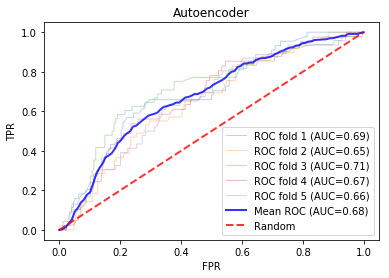

In [99]:
run_cv_autoencoder(X_Full, autoencoder, 5, "Autoencoder")

In [100]:
# Perform a 5-fold cross validation for a chosen model
def run_cv_no_model(X, folds, name):
    
    lr = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
    kf = KFold(n_splits=folds, shuffle=True)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    j = 0
    for train_index, test_index in kf.split(X):
        train = []
        test = []
        for index in train_index:
            train.append(X.iloc[index])
        train = np.array(train)
        for index in test_index:
            test.append(X.iloc[index])
        test = np.array(test)
        Xt = pd.DataFrame(train[:, :-1])
        Yt = train[:, -1]
        Xv = pd.DataFrame(test[:, :-1])
        Yv = test[:, -1]
        
        # Transform all the inputs given the chosen model and use that output to feed the LR
        lr.fit(Xt, Yt)
        #print lr.score(Xv, Yv)
        
        Yh = lr.predict(Xv)
        Yprob = lr.predict_proba(Xv)
        
        fpr, tpr, thresholds = roc_curve(Yv, Yprob[:,1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label="ROC fold %d (AUC=%0.2f)" % (j + 1, roc_auc))
        j = j + 1
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, lw=2, color='b', alpha=0.8, label='Mean ROC (AUC=%0.2f)' % (mean_auc))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(name)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
           label='Random', alpha=.8)
    plt.legend(loc="lower right")
    plt.show()

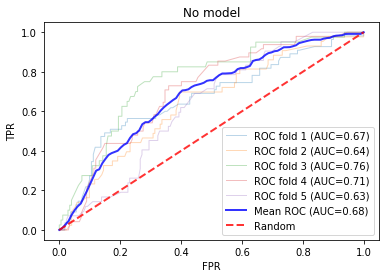

In [101]:
run_cv_no_model(X_Full, 5, "No model")

### Tests

In [246]:
np_rng = np.random.RandomState()
weights = 0.1 * np.random.rand(3, 2)
weights

array([[0.03158819, 0.01143351],
       [0.00914015, 0.06884196],
       [0.09950659, 0.04133751]])

In [295]:
y = np.array([0.2, 0.8])
y > np.random.random_sample(size=y.shape)

array([ True,  True])

In [312]:
rbm = RBM(12, 10, 0.1, 10, 1000)

In [326]:
rbm.gibbs_sample(X_0.iloc[0].values)

array([False,  True,  True, False,  True,  True, False,  True, False,
       False,  True, False])

In [602]:
#for batch in batch_iterator(X_0, batch_size=100):
#    print batch

In [692]:
X_0.values.sum(axis=0)

array([424, 631, 506, 465, 647, 552, 565, 813, 360, 593, 903, 207])

In [743]:
print X_0.values[:, :3].shape
print X_0.values[:, 3:6].shape

(1076, 3)
(1076, 3)


In [612]:
#X_0.iloc[:, 3:]

In [554]:
num_visible = 3
num_hidden = 10
num_historic = 9

# Initialize weights and biases
W = np.random.normal(scale=0.1, size=(num_visible, num_hidden))
a = np.zeros(num_visible)
b = np.zeros(num_hidden)
        
# Initialize autoregreesive parameters
A = np.random.normal(scale=0.01, size=(num_visible, num_historic))
B = np.random.normal(scale=0.01, size=(num_hidden, num_historic))

# Calculate the sigmoid of X 
def sigmoid(X):
    return 1 / (1 + np.exp(-1*X))
    
# Sample the activations given a certain matrix of probabilities
def sample(X):
    return X > np.random.random_sample(size=X.shape)

# Perform a reconstruction of the input data X
def gibbs_sample(X):
        
    # Separate input vector
    V = np.array(X.values[:, :3])
    H = np.array(X.values[:, 3:])
        
    # Positive phase
        
    # Calculate the contributions from the Historic layer
    dinamic_b = b + H.dot(B.T).sum(axis=0)
    print b
    print dinamic_b
        
    positive_hidden = sigmoid(V.dot(W) + dinamic_b)
    hidden_states = sample(positive_hidden)
        
    # Negative phase
        
    #Calculate the contributions from the Historic layer
    dinamic_a = a + H.dot(A.T).sum(axis=0)
        
    negative_visible = sigmoid(hidden_states.dot(W.T) + dinamic_a)
    visible_states = sample(negative_visible)
    return visible_states

In [603]:
#gibbs_sample(X_0)